# Water, Forest, Bare Soil Classification using Sentinel-1 SAR Mosaics

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-1' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\process-api\\cfg\\sentinel-1'

### _Load configuration file from repository cfg sub-directory_ 

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's1-mosaic-deforestation.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                var GAIN = 2.5;
                var WATER_LIMIT = 0.1;
                var FOREST_LIMIT = 0.2;
                var INVERSE_FACTOR = 25;
                var GREEN_GRADIENT = [
                    [1.000, 0x80F300],
                    [0.500, 0x406600],
                    [0.000, 0x003300]
                ]
                var RED_GRADIENT = [
                    [1.000, 0xFFFFFF],
                    [0.525, 0xFF8600],
                    [0.300, 0xFF6E00],
                    [0.250, 0xAE0000],
                    [0.000, 0x000000]
                ];
                let GREEN_VIZ = new ColorGradientVisualizer(GREEN_GRADIENT, 0, 1);
                let RED_VIZ = new ColorGradientVisualizer(RED_GRADIENT, 0, 1);
                
                function setup() {
                    return {
                        input: [{
                            bands: [ "VV", "VH" ]
                        }],
               

In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Create UTM bounding box over area of southern Borneo impacted by illegal deforestation_

In [7]:
# define min and max latlons
coords = 110.912476,-3.589515,112.601624,-2.339102
resolution = 100

In [8]:
# create instance of shclient class
from processapi import Client
client = Client( config )

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\sentinelhub\sh_utils.py:90: SHDeprecationWarning: Parameter base_url is deprecated and will soon be removed. Instead set config.sh_base_url = base_url and provide it with config parameter
  warnings.warn('Parameter base_url is deprecated and will soon be removed. Instead set '


In [9]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

490279.74523007293,9603245.068483569,678096.42042841,9741355.891860055 32749


### _Define January - March aggregation timeframes for 2019 - 2021_

In [10]:
import pandas as pd
from datetime import datetime

timeframes = []

# construct aggregation timeframes
#for year in [ 2019 ]:
for year in [ 2019, 2020, 2021 ]:
    
    # aggregation period - January to March
    timeframes.append( { 'start' : datetime( year, 1, 1, 0, 0, 0 ), 
                    'end' : datetime( year, 3, 31, 23, 59, 59 ) } )
timeframes

[{'start': datetime.datetime(2019, 1, 1, 0, 0),
  'end': datetime.datetime(2019, 3, 31, 23, 59, 59)},
 {'start': datetime.datetime(2020, 1, 1, 0, 0),
  'end': datetime.datetime(2020, 3, 31, 23, 59, 59)},
 {'start': datetime.datetime(2021, 1, 1, 0, 0),
  'end': datetime.datetime(2021, 3, 31, 23, 59, 59)}]

### _Extract S1 classification mosaics from Sentinel Hub using functionality of Process API client_ 

In [11]:
# grab mosaics from sentinel hub
response = client.getMosaics( bbox, timeframes, resolution )
response._df

default      start  \
0  [[[69, 113, 0], [31, 76, 0], [35, 79, 0], [64,... 2019-01-01   
1  [[[49, 90, 0], [0, 51, 0], [18, 65, 0], [73, 1... 2020-01-01   
2  [[[60, 99, 0], [40, 83, 0], [53, 93, 0], [61, ... 2021-01-01   

                  end  
0 2019-03-31 23:59:59  
1 2020-03-31 23:59:59  
2 2021-03-31 23:59:59

### _Display mosaic imagery superimposed onto OSM basemap_

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


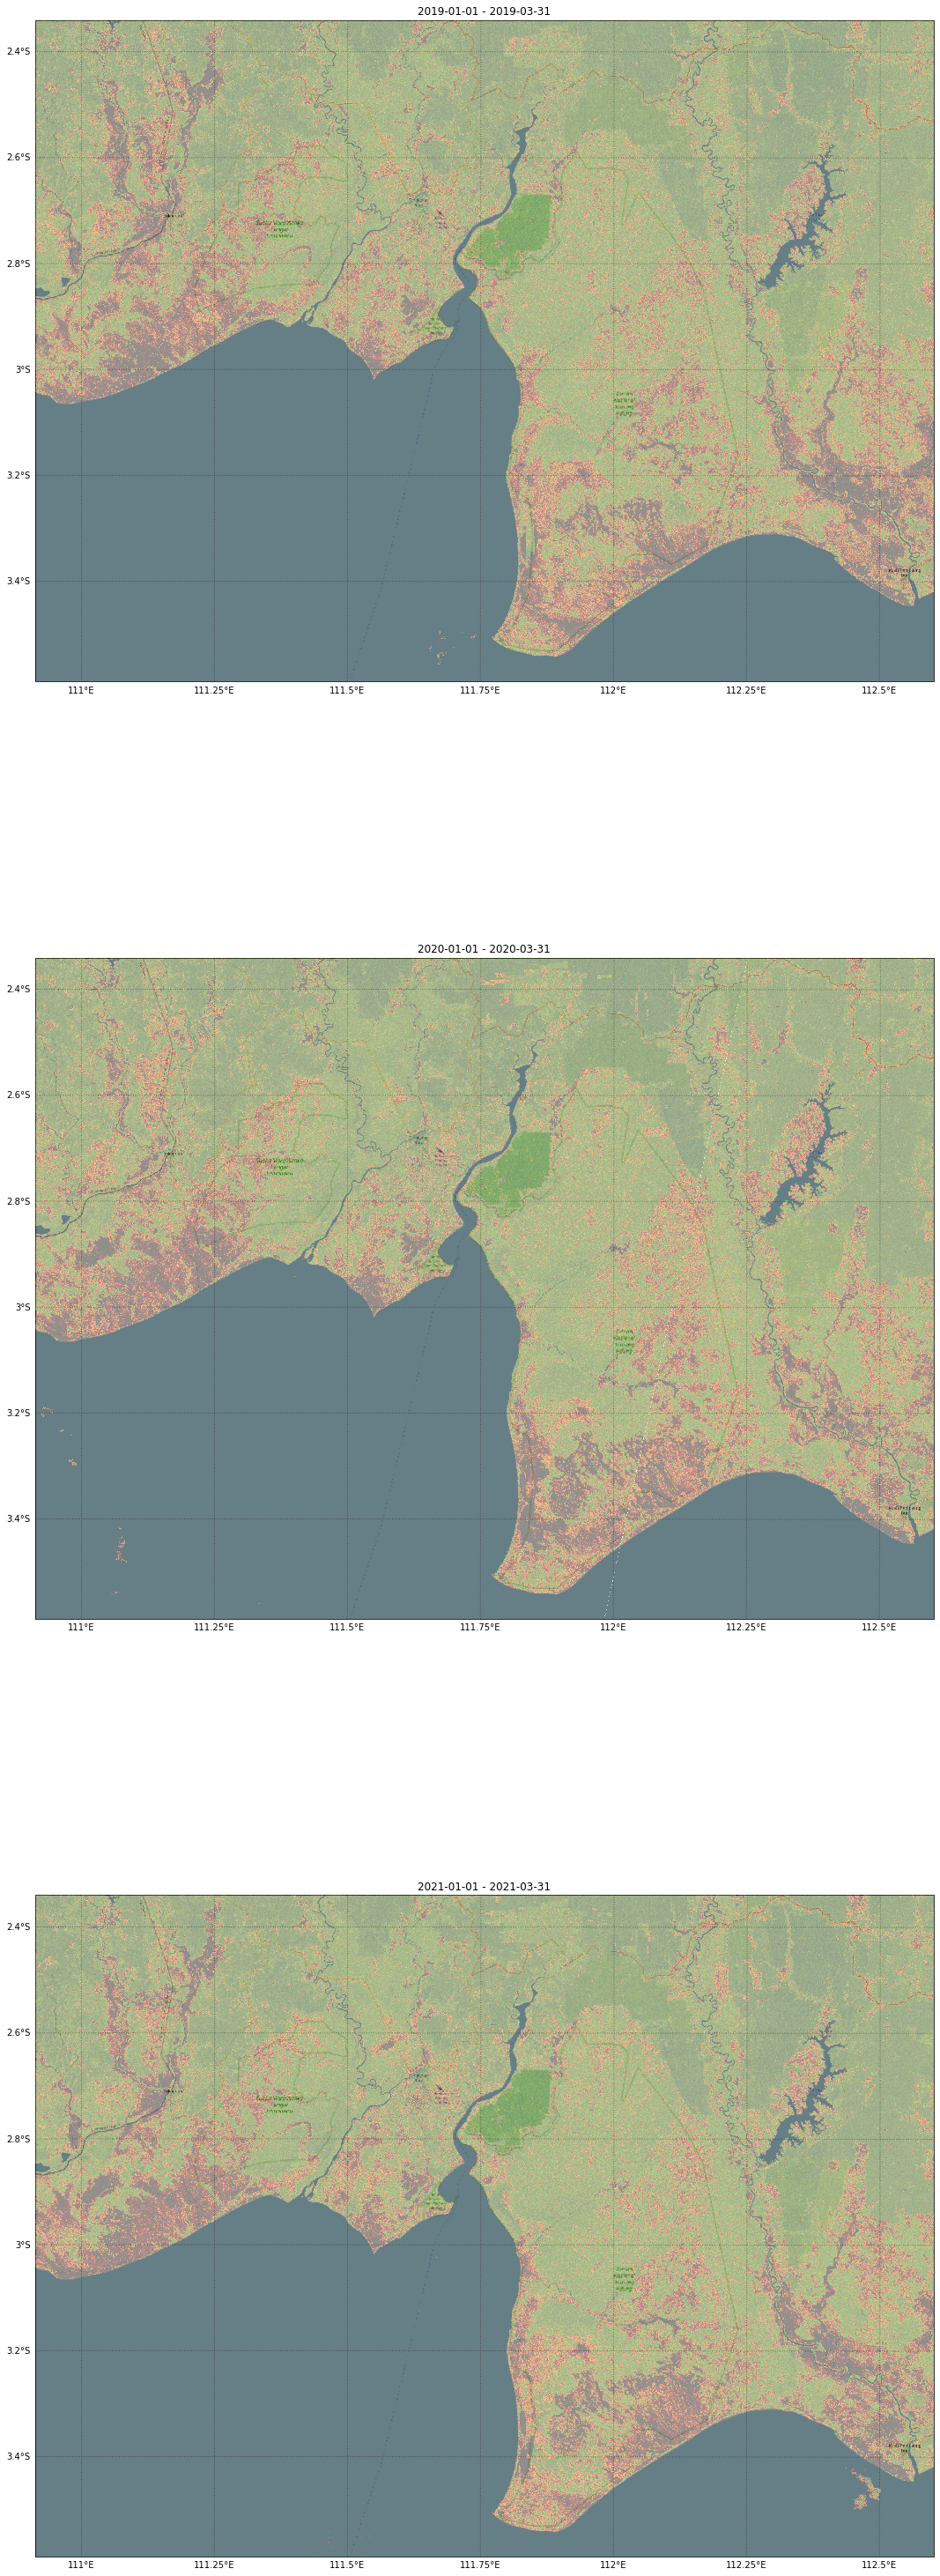

In [12]:
# plot time series
response.plotImages( 'default', osm_zoom=11 )